# Dimentionality reduction check for DEXSeq equation

In [ ]:
import pandas as pd
from opi import *

datastore = OPI()
from sklearn.decomposition import PCA
import umap
import matplotlib.pyplot as plt

# Always display only 5 rows in this NB
pd.set_option('display.max_rows', 5)

C:\Users\szollosb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Read in metadata_nacc_
metadata_nacc = pd.read_csv('metadata_nacc_.csv')

In [ ]:
# Get the unique sample indexes from metadata_nacc to use for query 
sample_idx = metadata_nacc['sample_index'].unique().tolist()
print(len(sample_idx))
sample_idx_str = ",".join(map(str, sample_idx))
print(sample_idx_str)

80
85772,85774,85775,85802,85803,85804,85805,85814,85819,85820,85823,85825,85828,85836,85837,85883,85884,85886,85907,85908,85909,85925,85941,85942,85943,85953,85954,85956,85966,85987,85988,85998,86002,86033,86039,86044,86045,86046,86047,220937,220940,220942,220944,220946,220949,220950,220952,220954,220958,220961,220962,220963,220964,220966,220967,220968,220970,220971,220972,220973,220976,220977,220978,220979,220981,220982,220983,220984,220985,220986,220988,220989,220993,220996,220998,221000,221003,221004,221005,221007


In [5]:
sql = f"""
SELECT ed.sample_index, ed.exon_index, ed.rpkm
FROM human_disease_b38_gc33.exon_data ed
WHERE ed.sample_index IN ({sample_idx_str})
"""
print(sql)
exon_data = datastore.query(sql)
display(exon_data)


SELECT ed.sample_index, ed.exon_index, ed.rpkm
FROM human_disease_b38_gc33.exon_data ed
WHERE ed.sample_index IN (85772,85774,85775,85802,85803,85804,85805,85814,85819,85820,85823,85825,85828,85836,85837,85883,85884,85886,85907,85908,85909,85925,85941,85942,85943,85953,85954,85956,85966,85987,85988,85998,86002,86033,86039,86044,86045,86046,86047,220937,220940,220942,220944,220946,220949,220950,220952,220954,220958,220961,220962,220963,220964,220966,220967,220968,220970,220971,220972,220973,220976,220977,220978,220979,220981,220982,220983,220984,220985,220986,220988,220989,220993,220996,220998,221000,221003,221004,221005,221007)



,sample_index,exon_index,rpkm
0,220937,158015,0.0
1,220940,158015,0.0
2,220942,158015,0.0
3,220944,158015,0.0
4,220946,158015,0.0
...,...,...,...
32241915,86039,248530,0.592119
32241916,86044,248530,0.631696
32241917,86045,248530,0.133412
32241918,86046,248530,0.456212


In [6]:
exon_index_data = exon_data.sort_values(by="exon_index")
print(exon_index_data["exon_index"].unique())
print(exon_index_data["sample_index"].unique())

<IntegerArray>
[     0,      1,      2,      3,      4,      5,      6,      7,      8,
      9,
 ...
 396435, 396436, 396437, 396438, 396439, 396440, 396441, 396442, 396443,
 396444]
Length: 396445, dtype: Int32
<IntegerArray>
[220950, 220958, 220954, 220952, 220961,  85883, 221005,  85772,  85828,
  85886,  85836,  85884,  86002,  85998,  85988,  85837, 220981, 220982,
  85775, 220970,  86033, 220977, 220978, 220979,  85907,  85774,  85966,
  85987, 221007, 221003, 220940, 221004, 220966, 220946, 220949,  85825,
 220944, 220942,  85909,  85908,  85956, 220976,  85953,  85954,  85925,
  85941,  85943,  85942,  86045,  85804,  85803,  85802,  85823,  85820,
  85819,  85814,  85805, 220971, 220968, 220967, 220972, 220996, 220937,
  86047, 220993, 220988, 220989,  86039, 220973, 220985, 220984, 220983,
 220964, 220963, 220962, 221000, 220998,  86046,  86044, 220986]
Length: 80, dtype: Int32


In [7]:
# Pivot table to make count matrix
# Pivot the long-format data to create a matrix (samples x exons)
count_matrix_rpkm = exon_data.pivot_table(index='sample_index',
                                           columns='exon_index',
                                           values='rpkm', 
                                           fill_value=0)
print(count_matrix_rpkm.head())

exon_index      0         1         2         3         4         5       \
sample_index                                                               
85772          0.07711  1.335343  0.755695  1.580455  0.554358  1.615729   
85774         0.082392  1.473036   1.70449  1.722711  0.551972  1.363181   
85775         0.060459  1.275431  0.835434  1.664654  0.555063  1.587748   
85802          0.07343  1.039177  0.831509  1.534999  0.528122  1.381044   
85803         0.094314  0.959891  0.920585  1.219371  0.541542  2.131401   

exon_index      6         7         8         9       ...  396435  396436  \
sample_index                                          ...                   
85772         1.082538   1.49147  1.145198  1.155601  ...     0.0     0.0   
85774          0.98292  1.517731  1.536992  1.533755  ...     0.0     0.0   
85775         1.105025  2.366797  1.759942  1.758886  ...     0.0     0.0   
85802         0.972948  1.129131  1.063431  1.070204  ...     0.0     0.0   
85803

In [8]:
count_matrix_rpkm.index.name = None
count_matrix_rpkm.columns.name = None
# Convert to DataFrame
count_matrix_rpkm = pd.DataFrame(count_matrix_rpkm)

print(count_matrix_rpkm.head())

# Save to csv
count_matrix_rpkm.to_csv('count_matrix_rpkm.csv', index=False)

         0         1         2         3         4         5         6       \
85772   0.07711  1.335343  0.755695  1.580455  0.554358  1.615729  1.082538   
85774  0.082392  1.473036   1.70449  1.722711  0.551972  1.363181   0.98292   
85775  0.060459  1.275431  0.835434  1.664654  0.555063  1.587748  1.105025   
85802   0.07343  1.039177  0.831509  1.534999  0.528122  1.381044  0.972948   
85803  0.094314  0.959891  0.920585  1.219371  0.541542  2.131401  1.439247   

         7         8         9       ...  396435  396436  396437  396438  \
85772   1.49147  1.145198  1.155601  ...     0.0     0.0     0.0     0.0   
85774  1.517731  1.536992  1.533755  ...     0.0     0.0     0.0     0.0   
85775  2.366797  1.759942  1.758886  ...     0.0     0.0     0.0     0.0   
85802  1.129131  1.063431  1.070204  ...     0.0     0.0     0.0     0.0   
85803  1.352364  1.169958  1.171166  ...     0.0     0.0     0.0     0.0   

       396439  396440  396441    396442  396443    396444  
85772   

In [9]:
# PCA
pca = PCA(n_components=2, random_state=0)
pcs = pca.fit_transform(count_matrix_rpkm)

In [39]:
# UMAP
um = umap.UMAP(n_components=2, random_state=42)
umap_fit = um.fit_transform(count_matrix_rpkm)

C:\Users\szollosb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\szollosb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [10]:
pca_df = pd.DataFrame(pcs, index=count_matrix_rpkm.index, columns=['PC1', 'PC2'])
# 1. Make sure your metadata is indexed by sample_index
metadata_nacc = metadata_nacc.set_index('sample_index')

# 3. Join it onto your count matrix (aligns on the index)
joined_df = pca_df.join(metadata_nacc)

# Now count_with_disease has all the original expression columns
# plus a new column 'disease_state'

In [74]:
joined_df.head()

,PC1,PC2,age_summary,disease_state,ethnicity,gender,tissue,disease,title,age,subject_id
85772,-88937.201430,5538.099144,31 years,schizophrenia,White,female,nucleus accumbens,mental disorder,RNA-sequencing of human post-mortem brain tissues,31,GSE80655_X2353
85774,-86216.499907,-2236.383692,45 years,normal control,White,male,nucleus accumbens,mental disorder,RNA-sequencing of human post-mortem brain tissues,45,NaN
85775,-85899.128095,-4672.190853,53 years,schizophrenia,White,female,nucleus accumbens,mental disorder,RNA-sequencing of human post-mortem brain tissues,53,GSE80655_X2976
85802,-85107.681269,-8580.574840,70 years,normal control,White,male,nucleus accumbens,mental disorder,RNA-sequencing of human post-mortem brain tissues,70,NaN
85803,-86172.140202,-3099.245899,35 years,normal control,White,male,nucleus accumbens,mental disorder,RNA-sequencing of human post-mortem brain tissues,35,NaN


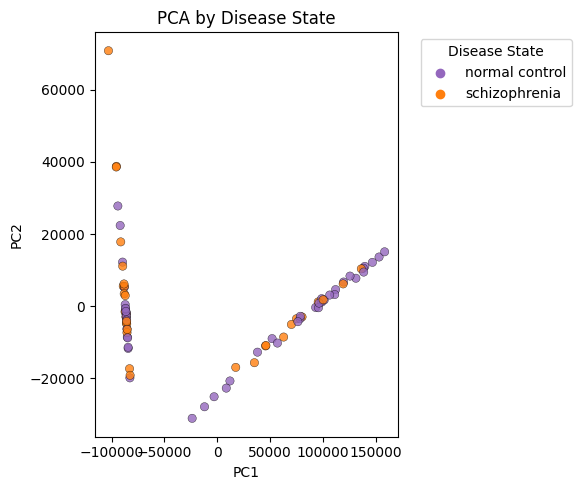

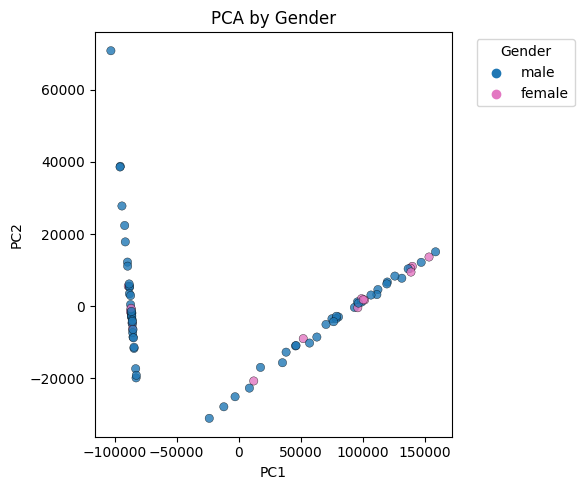

C:\Users\szollosb\AppData\Local\Temp\ipykernel_25524\3291222037.py:46: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


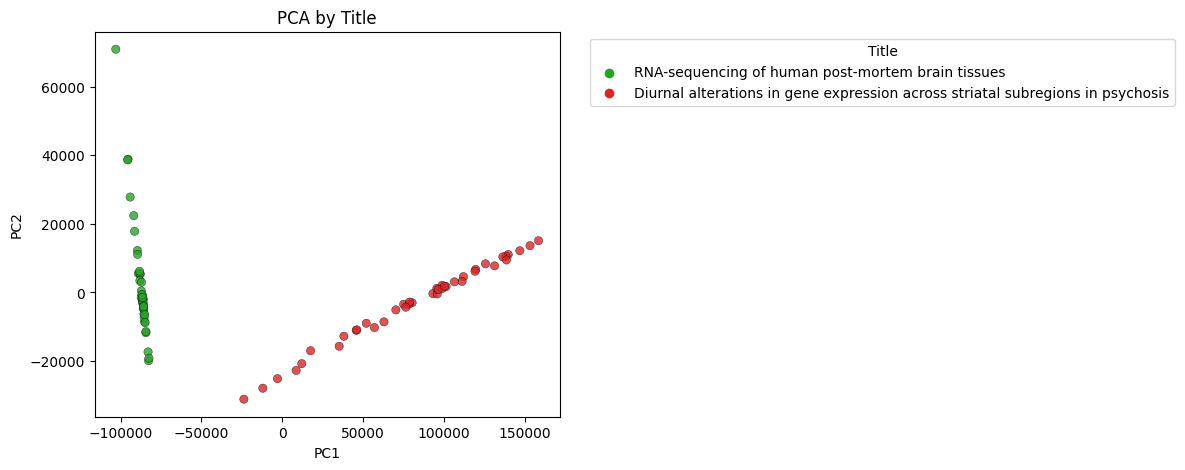

In [11]:

# 1) Define which metadata columns you want to plot and their color maps:
plot_cols = {
    'disease_state': {
        'normal control': 'tab:purple',
        'schizophrenia':   'tab:orange',
    },
    'gender': {
        'male':   'tab:blue',
        'female': 'tab:pink',
    },
    'title': {
        'RNA-sequencing of human post-mortem brain tissues':    'tab:green',
        'Diurnal alterations in gene expression across striatal subregions in psychosis':    'tab:red',
    },
}

# 2) Loop through them and make one figure per column:
for meta_col, color_map in plot_cols.items():
    # map your metadata to colors
    colors = joined_df[meta_col].map(color_map)
    
    # sanity check: any unmapped values?
    missing = joined_df[meta_col][colors.isna()].unique()
    if len(missing):
        print(f"Warning: unmapped categories in '{meta_col}': {missing}")
    
    # plot
    plt.figure(figsize=(6,5))
    plt.scatter(
        joined_df['PC1'],
        joined_df['PC2'],
        c=colors,
        alpha=0.8,
        edgecolor='k',
        linewidth=0.3
    )
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title(f'PCA by {meta_col.replace("_", " ").title()}')
    
    # custom legend
    for category, col in color_map.items():
        plt.scatter([], [], color=col, label=category)
    plt.legend(title=meta_col.replace('_', ' ').title(), bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()


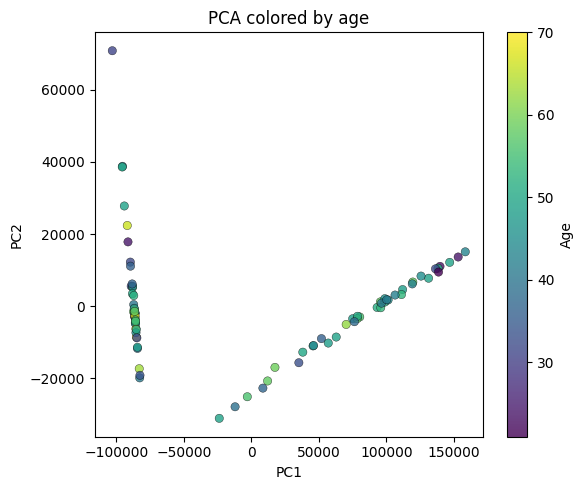

In [16]:
plt.figure(figsize=(6,5))
sc = plt.scatter(
    joined_df['PC1'],
    joined_df['PC2'],
    c=joined_df['age'],          # continuous values
    cmap='viridis',              # a perceptually uniform colormap
    alpha=0.8,
    edgecolor='k',
    linewidth=0.3
)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA colored by age')
cb = plt.colorbar(sc)
cb.set_label('Age')

plt.tight_layout()
plt.show()

In [77]:
umap_df = pd.DataFrame(umap_fit, index=count_matrix_rpkm.index, columns=['UM1', 'UM2'])

# 3. Join it onto your count matrix (aligns on the index)
joined_umap = umap_df.join(metadata_nacc)

# Now count_with_disease has all the original expression columns
# plus a new column 'disease_state
joined_umap.head()

,UM1,UM2,age_summary,disease_state,ethnicity,gender,tissue,disease,title,age,subject_id
85772,8.328219,9.787857,31 years,schizophrenia,White,female,nucleus accumbens,mental disorder,RNA-sequencing of human post-mortem brain tissues,31,GSE80655_X2353
85774,6.906013,9.217395,45 years,normal control,White,male,nucleus accumbens,mental disorder,RNA-sequencing of human post-mortem brain tissues,45,NaN
85775,7.042532,8.688415,53 years,schizophrenia,White,female,nucleus accumbens,mental disorder,RNA-sequencing of human post-mortem brain tissues,53,GSE80655_X2976
85802,7.284142,8.088073,70 years,normal control,White,male,nucleus accumbens,mental disorder,RNA-sequencing of human post-mortem brain tissues,70,NaN
85803,7.134799,8.678915,35 years,normal control,White,male,nucleus accumbens,mental disorder,RNA-sequencing of human post-mortem brain tissues,35,NaN


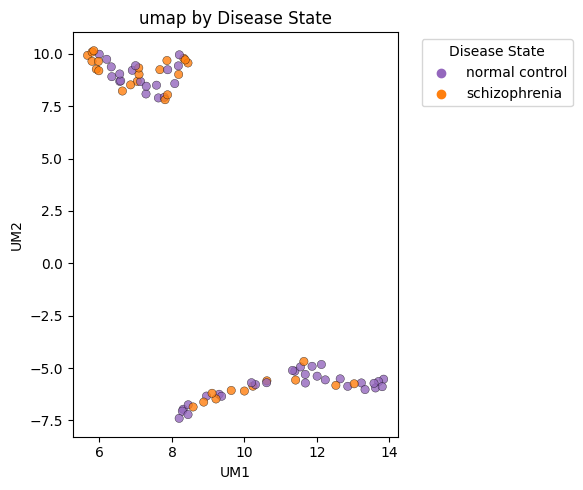

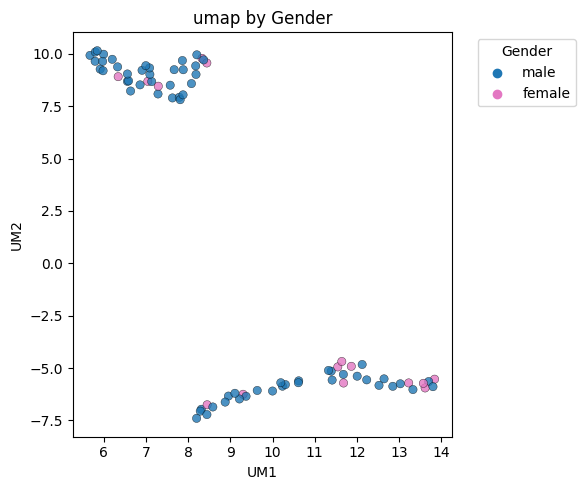

C:\Users\szollosb\AppData\Local\Temp\ipykernel_85172\118778975.py:30: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


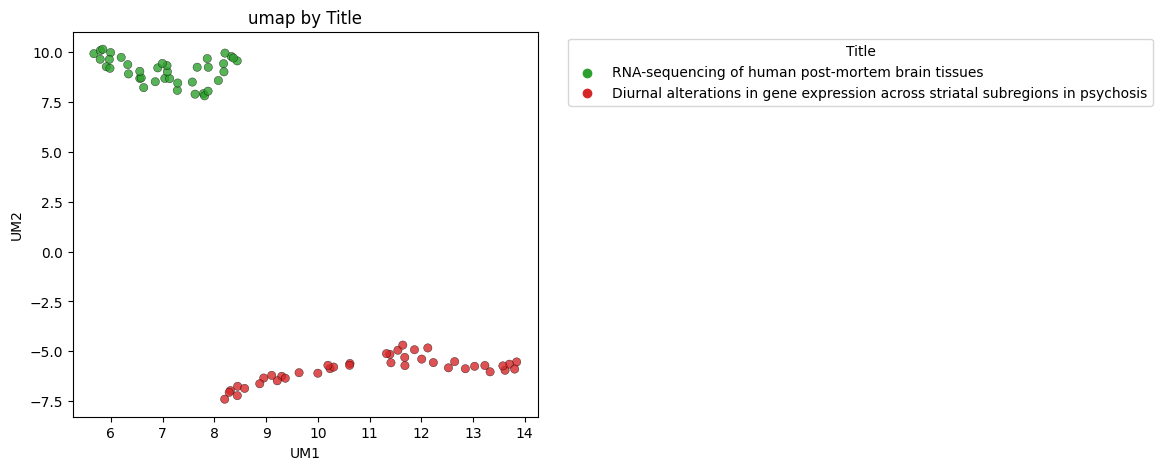

In [79]:
# 2) Loop through them and make one figure per column:
for meta_col, color_map in plot_cols.items():
    # map your metadata to colors
    colors = joined_umap[meta_col].map(color_map)
    
    # sanity check: any unmapped values?
    missing = joined_umap[meta_col][colors.isna()].unique()
    if len(missing):
        print(f"Warning: unmapped categories in '{meta_col}': {missing}")
    
    # plot
    plt.figure(figsize=(6,5))
    plt.scatter(
        joined_umap['UM1'],
        joined_umap['UM2'],
        c=colors,
        alpha=0.8,
        edgecolor='k',
        linewidth=0.3
    )
    plt.xlabel('UM1')
    plt.ylabel('UM2')
    plt.title(f'umap by {meta_col.replace("_", " ").title()}')
    
    # custom legend
    for category, col in color_map.items():
        plt.scatter([], [], color=col, label=category)
    plt.legend(title=meta_col.replace('_', ' ').title(), bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()



In [19]:
exon_data = pd.read_csv('exon_annotation_nacc.csv')

len(exon_data['gene_name'].unique())

C:\Users\szollosb\AppData\Local\Temp\ipykernel_25524\2709360846.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  exon_data = pd.read_csv('exon_annotation_nacc.csv')


60615